## How to Train a Convolutional Neural Network (CNN) Optimally


In this notebook we conduct the same investigation for CNNs that we performed in the previous notebook in the context of dense DNNs. More specifically, our goal is to determine optimal choices for the following three factors that achieve both effectiveness (high test accuracy) and efficiency (faster convergence) in training CNNs.

- Weight initializer
- Activation function
- Learning rate setting technique


## DNN Architecture 
We create a 4 hidden layer based CNN followed by one dense layer and final output layer.
- In all experiments we train the CNN for 100 fixed epochs. We don't use early stopping for the convenience of comparison.
- We use increasing dropout rate for the four hidden layers: 0.2, 0.3, 0.4, 0.5.

## Dataset
We use the CIFAR10 dataset that we used in the previous notebook.


## Experiments

We perform following experiments.

- Experiment 1: Batch Normalization 
 
         -- a) He initializer + ELU activation + NAdam (lr=0.001)
         -- b) He initializer + ELU activation + 1cycle Learning Schedule

- Experiment 2: Pretraining based Weight Initialization with 1cycle Learning Schedule
 
         -- a) Orthogonal Initializer 
         -- b) He Initializer

- Experiment 3: Orthogonal Initializer + ELU activation

      -- a) 1cycle Learning Schedule
      -- b) NAdam (lr=0.001)

- Experiment 4: He Initializer + ELU activation + 1cycle Learning Schedule

        These experiments are conducted on a GPU from Google Colaboratory.




In [1]:
import warnings
import os
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import tensorflow as tf
from tensorflow import keras


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

In [2]:
# Check whether a GPU is added
tf.test.gpu_device_name()

'/device:GPU:0'

## Load and Scale the Dataset

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train_full = X_train_full.astype('float32')
X_test = X_test.astype('float32')

X_train = X_train_full[5000:]/255.0
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]/255.0
y_valid = y_train_full[:5000]

X_test = X_test/255.0

print("\nShape of Training Samples: ", X_train.shape)
print("Shape of Training Labels: ", y_train.shape)

print("\nShape of Validation Samples: ", X_valid.shape)
print("Shape of Validation Labels: ", y_valid.shape)

print("\nShape of Testing Samples: ", X_test.shape)
print("Shape of Testing Labels: ", y_test.shape)

print("\nData type: ", X_train.dtype)
print("Label type: ", y_train.dtype)

170500096/170498071 [==============================] - 6s 0us/step

Shape of Training Samples:  (45000, 32, 32, 3)
Shape of Training Labels:  (45000, 1)

Shape of Validation Samples:  (5000, 32, 32, 3)
Shape of Validation Labels:  (5000, 1)

Shape of Testing Samples:  (10000, 32, 32, 3)
Shape of Testing Labels:  (10000, 1)

Data type:  float32
Label type:  uint8


## Display a Set of Images

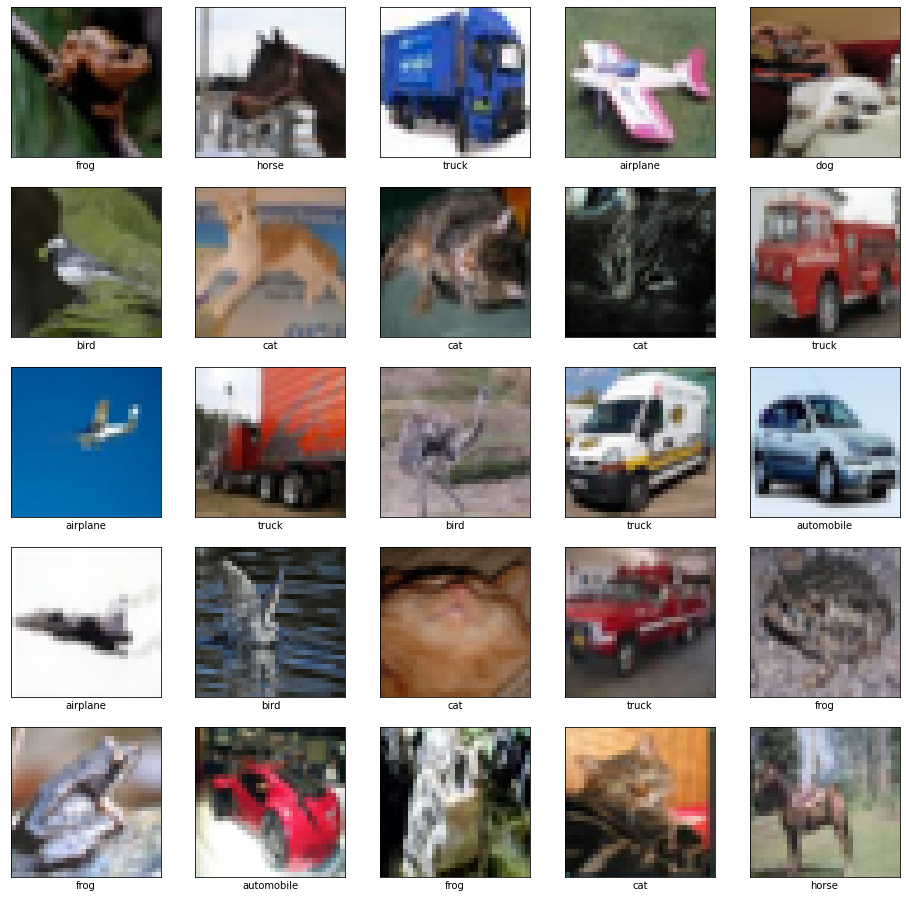

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(16,16))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    # The CIFAR labels are arrays, that's why we use the extra index
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

## Functions for Various Learning Curves & Converting Training Time

In [5]:
'''
Function For Generating Learning Curves (Accuracy & Loss)
'''
def plot_learning_curves(history, numOfEpochs, title):
    plt.figure(figsize=(18,6))

    plt.subplot(121)
    plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
    plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
    plt.legend(loc=0)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([1,numOfEpochs])
    plt.grid(True)
    plt.title("Model Accuracy: "+title)
    
    plt.subplot(122)
    plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
    plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
    plt.legend(loc=0)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim([1,numOfEpochs])
    plt.grid(True)
    plt.title("Model Loss: "+title)
    
    plt.show() 
    
    
# Plot learning rate & momentum
def plot_learning_rate(loss_history_lschedule, numOfEpochs, title, momentumPlot=False):
    plt.figure(figsize=(10,6))
    plt.plot(range(1,numOfEpochs+1),loss_history_lschedule.lr,label='learning rate')
    plt.xlabel("Epoch")
    plt.xlim([1,numOfEpochs+1])
    plt.ylabel("Learning rate")
    
    if(momentumPlot==True):
        plt.plot(range(1,numOfEpochs+1),loss_history_lschedule.mom,'r-', label='momentum')
        plt.ylabel("Learning rate & Momentum")
    
    
    plt.legend(loc=0)
    plt.grid(True)
    plt.title(title)
    plt.show()

    
'''
Function to Convert Seconds into Hours, Minutes and Seconds
'''
def convertTime(seconds): 
    seconds = seconds % (24 * 3600) 
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    
    if(hour == 0):
        return "{0:2.0f} min {1:2.0f} s".format(minutes, seconds) 
    
    elif(hour == 0 and minutes == 0):
        return "{1:2.0f} s".format(seconds) 
    
    else:
        return "{0:2.0f} h {1:2.0f} min {2:2.0f} s".format(hour, minutes, seconds) 

## Class to store the Changing Loss and Learning Rates

In [6]:
K = keras.backend
        
# A class to store the changing loss and learning rates at each epoch.
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(K.get_value(self.model.optimizer.lr))

## Class for 1cycle Learning Schedule

In [7]:
class OneCycle(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, momentum_vals=(0.95, 0.85), start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
        
        self.step_len =  int(self.iterations * (1 - 10.0/100.0)/2)
        
        self.low_mom = momentum_vals[1]
        self.high_mom = momentum_vals[0]
        
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    
    def on_batch_begin(self, batch, logs):
        
        # Set Learning Rate
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)
        
        
        # Set Momentum
        if self.iteration == 0:
            return self.high_mom
        elif self.iteration == self.iterations:
            self.iteration = 0
            return self.high_mom
        elif self.iteration > 2 * self.step_len:
            mom = self.high_mom
        elif self.iteration > self.step_len:
            ratio = (self.iteration - self.step_len)/self.step_len
            mom = self.low_mom + ratio * (self.high_mom - self.low_mom)
        else :
            ratio = self.iteration/self.step_len
            mom = self.high_mom - ratio * (self.high_mom - self.low_mom)
        K.set_value(self.model.optimizer.momentum, mom)

        
        
K = keras.backend
        
# A class to store the changing loss and learning rates at each epoch.
class LossHistory_OneCycle(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        self.mom = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(K.get_value(self.model.optimizer.lr))
        self.mom.append(K.get_value(self.model.optimizer.momentum))

## Function for Increasing Learning Rate

In [8]:
'''
A class to increase the learning rate by a "factor" at each iteration.
It stores the changing learning rate and loss at each iteration.
'''

K = keras.backend

class IncreaseLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)
   

        
'''
Function to determine the "factor" to be used in the IncreaseLearningRate (above) object
'''
def computeFactorForIncreasingLearningRate(X, size_mini_batch, no_of_epochs, upper_bound_lr, lower_bound_lr):
    
    # Total number of iterations
    iterations = len(X) // size_mini_batch * no_of_epochs
    
    factor = np.exp(np.log(upper_bound_lr / lower_bound_lr) / iterations)
    
    return factor

## Experiment 1 (a): Batch Normalization

He initializer + ELU activation + NAdam optimizer (lr=0.001)

In [9]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''


initializer = 'he_normal'
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer = keras.optimizers.Nadam(lr=0.001)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


'''
Create loss history call back object
'''
loss_history_cb = LossHistory()

model_name = "CIFAR10_CNN_He_ELU_VarDrop_BN"
model_name_format = "CIFAR10_CNN_He_ELU_VarDrop_BN.h5"

'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)

'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)


'''
Train the model
'''
no_of_epochs = 100
size_of_mini_batch = 64
t0 = time.time()
history_CNN_He_ELU_VarDrop_BN = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, loss_history_cb])
t1 = time.time()

duration_CNN_He_ELU_VarDrop_BN_sec = t1-t0
duration_CNN_He_ELU_VarDrop_BN = convertTime(duration_CNN_He_ELU_VarDrop_BN_sec)
print("\nTraining Time: ", duration_CNN_He_ELU_VarDrop_BN)
print("\n")

'''
Save the model
'''
model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 29s 41ms/step - loss: 1.6207 - accuracy: 0.4544 - val_loss: 1.1361 - val_accuracy: 0.6034
Epoch 2/100
704/704 [==============================] - 28s 40ms/step - loss: 1.0837 - accuracy: 0.6167 - val_loss: 0.9394 - val_accuracy: 0.6656
Epoch 3/100
704/704 [==============================] - 29s 41ms/step - loss: 0.9146 - accuracy: 0.6808 - val_loss: 0.8050 - val_accuracy: 0.7142
Epoch 4/100
704/704 [==============================] - 29s 41ms/step - loss: 0.8146 - accuracy: 0.7176 - val_loss: 0.7203 - val_accuracy: 0.7482
Epoch 5/100
704/704 [==============================] - 28s 40ms/step - loss: 0.7402 - accuracy: 0.7439 - val_loss: 0.8387 - val_accuracy: 0.7352
Epoch 6/100
704/704 [==============================] - 29s 41ms/step - loss: 0.6853 - accuracy: 0.7662 - val_loss: 0.6201 - val_accuracy: 0.7890
Epoch 7/100
704/704 [==============================] - 28s 40ms/step - loss: 0.6329 - accuracy: 0.7826 - val_loss: 0.6616 - val_ac

Epochs:  100

CIFAR10_CNN_He_ELU_VarDrop_BN Test Accuracy: 0.863
CIFAR10_CNN_He_ELU_VarDrop_BN Test Loss: 0.526

Test Confusion Matrix:
[[873   7  15   9  10   3   6   8  44  25]
 [  8 921   0   1   1   1   4   1  13  50]
 [ 52   1 745  44  57  43  37  13   5   3]
 [ 14   3  22 711  37 132  42  21   8  10]
 [  2   2  21  20 866  24  35  27   3   0]
 [  8   0   9  85  36 810  17  34   1   0]
 [  2   1   9  18  10  10 942   5   2   1]
 [  5   0  13  15  25  32   8 898   2   2]
 [ 29   6   3   5   1   0   3   2 937  14]
 [ 10  34   2   3   0   3   4   2  11 931]]


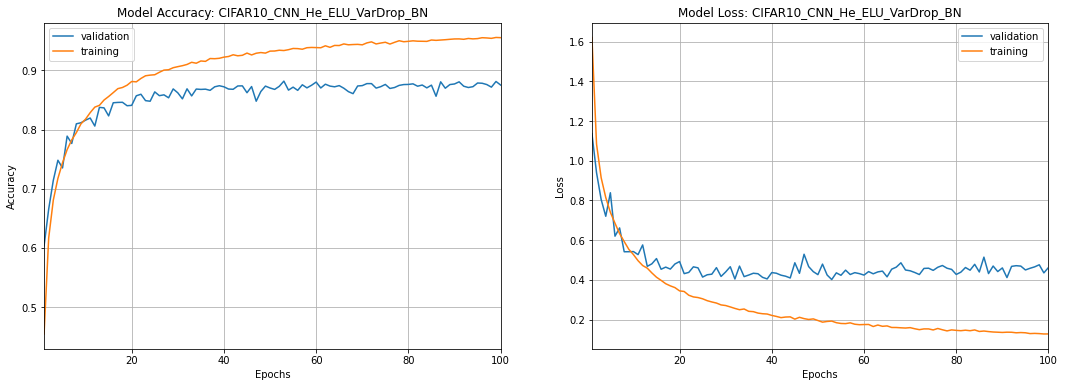

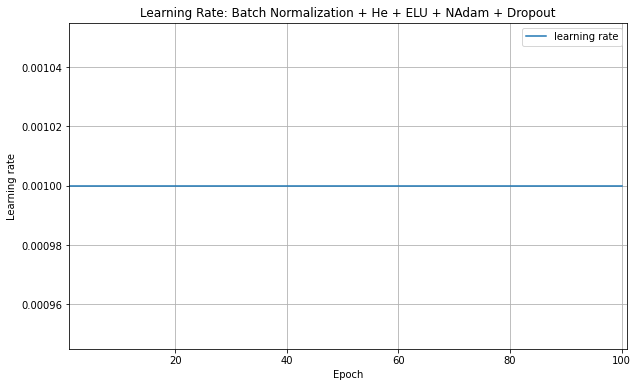

In [10]:
# Load the saved model for making predictions
#model = keras.models.load_model("CIFAR10_CNN_He_ELU_VarDropout_BN.h5")

numOfEpochs_CNN_He_ELU_VarDrop_BN = len(history_CNN_He_ELU_VarDrop_BN.history['loss'])
print("Epochs: ", numOfEpochs_CNN_He_ELU_VarDrop_BN)

test_loss_CNN_He_ELU_VarDrop_BN, test_accuracy_CNN_He_ELU_VarDrop_BN = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_CNN_He_ELU_VarDrop_BN))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_CNN_He_ELU_VarDrop_BN))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_CNN_He_ELU_VarDrop_BN, numOfEpochs_CNN_He_ELU_VarDrop_BN, 
                     model_name)

plot_learning_rate(loss_history_cb, numOfEpochs_CNN_He_ELU_VarDrop_BN, 
                   "Learning Rate: Batch Normalization + He + ELU + NAdam + Dropout", momentumPlot=False)

## Expriment 1(b): Batch Normalization

Instead of using the NAdam optimizer we use 1cycle learning rate schedule with He initializer and ELU activation.


### Find Maximum Learning Rate for 1cycle Schedule

In [12]:

%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''


initializer = 'he_normal'
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



# Define the optimizer
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

'''
Create an IncreaseLearningRate object.
It increases the learning rate by 0.5% at each iteration:
We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration.
'''
size_mini_batch = 64
no_of_epochs = 1
upper_bound_lr = 0.5
lower_bound_lr = 1e-3
increase_factor = computeFactorForIncreasingLearningRate(X_train, size_mini_batch, no_of_epochs, 
                                                         upper_bound_lr, lower_bound_lr)
increase_lr_cb = IncreaseLearningRate(factor=increase_factor)

'''
Train the model
'''
model.fit(X_train, y_train, 
                    batch_size=size_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[increase_lr_cb])

704/704 [==============================] - 22s 31ms/step - loss: 2.2983 - accuracy: 0.2960 - val_loss: 13.0849 - val_accuracy: 0.1668
CPU times: user 17 s, sys: 3.77 s, total: 20.8 s
Wall time: 24 s


## Learning rate vs Loss Plot

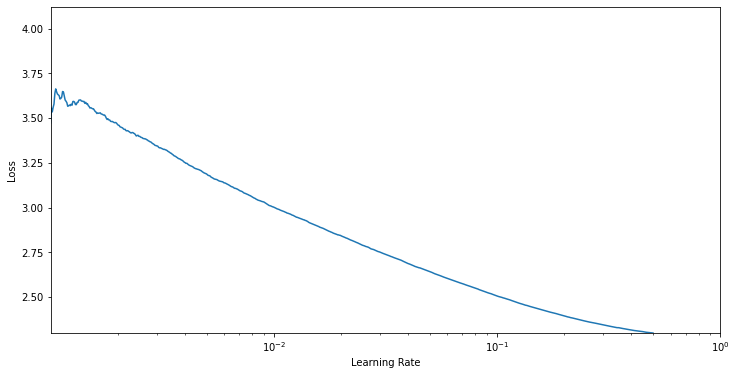

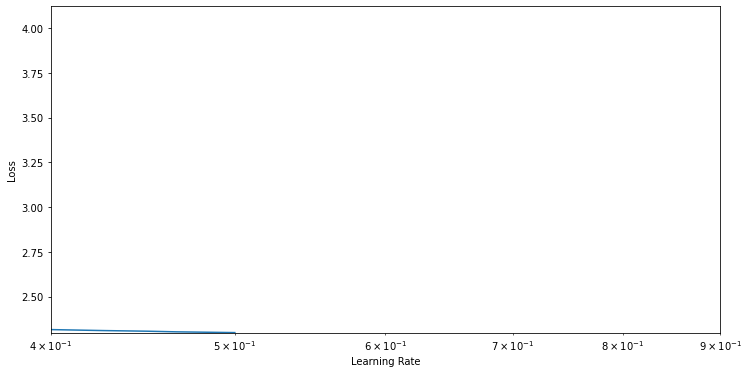

In [13]:
plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(min(increase_lr_cb.rates), 1)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()


plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(0.4, 0.9)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()

## Max Learning Rate for 1cycle Schedule

From the above plot we see that the max learning rate is 0.5 at which los is minimum.

In [14]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

initializer = 'he_normal'
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


loss_history_oneCycle_cb = LossHistory_OneCycle()


model_name = "CIFAR10_CNN_BN_1cycle"
model_name_format = "CIFAR10_CNN_BN_1cycle.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)


no_of_epochs = 100
size_of_mini_batch = 64
no_iterations = (len(X_train) // size_of_mini_batch) * no_of_epochs


lschedule_oneCycle_cb = OneCycle(no_iterations, max_rate=0.5, momentum_vals=(0.95, 0.85))


t0 = time.time()
history_CNN_BN_1cycle = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, lschedule_oneCycle_cb, loss_history_oneCycle_cb])
t1 = time.time()

duration_CNN_BN_1cycle_sec = t1-t0
duration_CNN_BN_1cycle = convertTime(duration_CNN_BN_1cycle_sec)
print("\nTraining Time: ", duration_CNN_BN_1cycle)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 23s 32ms/step - loss: 1.6147 - accuracy: 0.4325 - val_loss: 1.3916 - val_accuracy: 0.5046
Epoch 2/100
704/704 [==============================] - 22s 32ms/step - loss: 1.2139 - accuracy: 0.5642 - val_loss: 1.4192 - val_accuracy: 0.5260
Epoch 3/100
704/704 [==============================] - 22s 32ms/step - loss: 1.0747 - accuracy: 0.6163 - val_loss: 1.1461 - val_accuracy: 0.6108
Epoch 4/100
704/704 [==============================] - 22s 32ms/step - loss: 0.9802 - accuracy: 0.6550 - val_loss: 0.9516 - val_accuracy: 0.6582
Epoch 5/100
704/704 [==============================] - 22s 32ms/step - loss: 0.9028 - accuracy: 0.6818 - val_loss: 1.4743 - val_accuracy: 0.5756
Epoch 6/100
704/704 [==============================] - 22s 32ms/step - loss: 0.8504 - accuracy: 0.7049 - val_loss: 1.1166 - val_accuracy: 0.6206
Epoch 7/100
704/704 [==============================] - 22s 31ms/step - loss: 0.7948 - accuracy: 0.7219 - val_loss: 1.3263 - val_ac

Epochs:  100

CIFAR10_CNN_BN_1cycle Test Accuracy: 0.879
CIFAR10_CNN_BN_1cycle Test Loss: 0.508

Test Confusion Matrix:
[[892   7  22  10   2   3   3   9  35  17]
 [  7 941   1   0   2   0   2   0   6  41]
 [ 29   1 809  41  40  34  24  14   6   2]
 [ 10   2  28 778  21 111  29  11   3   7]
 [  6   1  27  38 852  23  21  27   4   1]
 [  7   1  12 108  21 822   6  17   0   6]
 [  2   0  17  36   9   5 925   2   2   2]
 [  6   0   9  22  28  28   1 901   2   3]
 [ 29  12   2   5   1   2   5   0 930  14]
 [  8  36   2   3   0   1   2   1   7 940]]


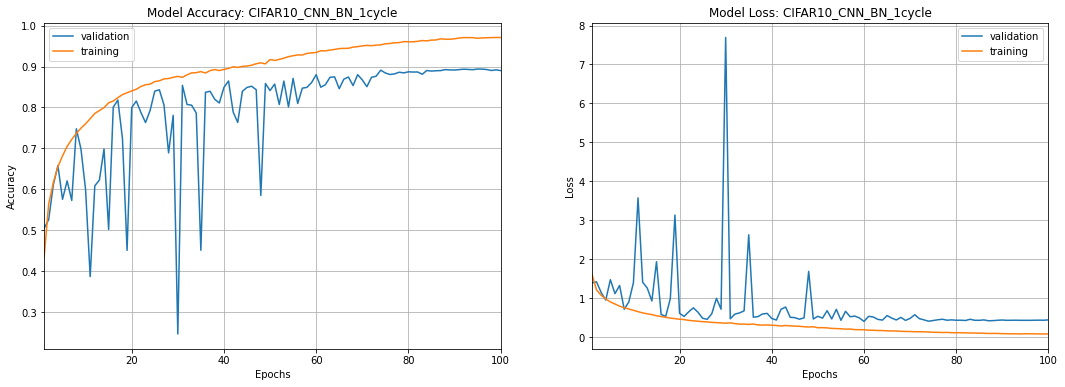

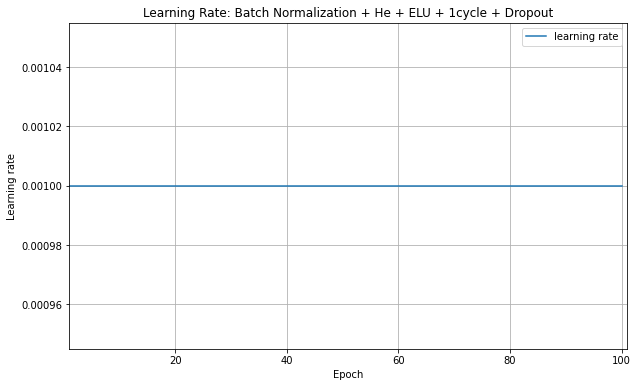

In [15]:
# Load the saved model for making predictions
#model = keras.models.load_model("CIFAR10_CNN_BN_1cycle.h5")

numOfEpochs_CNN_BN_1cycle = len(history_CNN_BN_1cycle.history['loss'])
print("Epochs: ", numOfEpochs_CNN_BN_1cycle)

test_loss_CNN_BN_1cycle, test_accuracy_CNN_BN_1cycle = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_CNN_BN_1cycle))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_CNN_BN_1cycle))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_CNN_BN_1cycle, numOfEpochs_CNN_BN_1cycle, 
                     model_name)

plot_learning_rate(loss_history_cb, numOfEpochs_CNN_BN_1cycle, 
                   "Learning Rate: Batch Normalization + He + ELU + 1cycle + Dropout", momentumPlot=False)

## Experiment 2: Pretraining based Weight Initialization


In this experiment we initialize the weights of the CNN via pretraining. We use a small subset of the training data (with only 2 classes) to train the CNN architecture. Then, using the pretrained layers (except the last two hidden layers and the final layer) as initial weights, we train the CNN using full training data. There are two steps in this pretraining based initialization approach:

- Step 1: Initialize weights by pretraining using a smaller training data
- Step 2: Fine-tune using full training data

For the pretraining part, we use the orthogonal weight initializer and ELU activation function. The model is regularized by using increasing dropout rate in the 4 hidden layers: 0.2, 0.3, 0.4 and 0.5. We pretrain the model for 10 fixed epochs. Within 10 epochs the validation accuracy reaches to 95%.

We set the SGD learning rate using the 1cycle learning schedule. For this, first we find the maximum learning rate. Then, using the maximum learning rate for 1cycle schedule we pretrain the model.

For the fine-tuning, we use the weights of first 2 hidden layers of the pretrained model and add last two hidden layers as well as the output layer. These new layers are initialized using orthogonal weight initializer (2(a)) along with ELU activation. We use the same maximum learning rate for 1cycle learning schedule to train the model for fixed 100 epochs.

In addition to this, we perform another experiment (2(b)) in which we keep the above setting unchanged except the orthogonal initializer is replaced by He initializer.

Thus, there are two pretraining based experiments:
- Experiment 2(a):  Pretraining based Weight Initialization with Orthogonal Initializer

- Experiment 2(b):  Pretraining based Weight Initialization with He Initializer



## Create Small Training & Validation Set
We use 1/5 of the labels to create a smaller training and validation dataset. Effectively the training set is reduced by a factor of 5.

For this experiment, we only use the first two classes for pretraining. For these two classes all training data are used.

In [50]:
'''
Create the smaller training subset
'''

count_few_labels = 0
for i in range(X_train.shape[0]):
    if(y_train[i] == 0 or y_train[i] == 1):
        count_few_labels += 1
    

X_train_small = np.zeros((count_few_labels, 32,32,3), 'float32')
y_train_small = np.zeros((count_few_labels, 1), 'uint8')

j = 0
for i in range(X_train.shape[0]):
    if(y_train[i] == 0 or y_train[i] == 1):
        X_train_small[j] = X_train[i]
        y_train_small[j] = y_train[i]
        j += 1
        
        
print("\nShape of Small Training Samples: ", X_train_small.shape)
print("Shape of Small Training Labels: ", y_train_small.shape)


Shape of Small Training Samples:  (9035, 32, 32, 3)
Shape of Small Training Labels:  (9035, 1)


In [51]:
'''
Create the smaller validation subset
'''

count_few_labels_valid = 0
for i in range(X_valid.shape[0]):
    if(y_valid[i] == 0 or y_valid[i] == 1):
        count_few_labels_valid += 1
    

X_valid_small = np.zeros((count_few_labels_valid, 32,32,3), 'float64')

y_valid_small = np.zeros((count_few_labels_valid, 1), 'uint8')

j = 0
for i in range(X_valid.shape[0]):
    if(y_valid[i] == 0 or y_valid[i] == 1):
        X_valid_small[j] = X_valid[i]
        y_valid_small[j] = y_valid[i]
        j += 1
        
        
print("\nShape of Small Validation Samples: ", X_valid_small.shape)
print("Shape of Small Validation Labels: ", y_valid_small.shape)


Shape of Small Validation Samples:  (965, 32, 32, 3)
Shape of Small Validation Labels:  (965, 1)


## Experiment 2(a): Weight Initialization by Pretraining using Orthogonal Initializer


##### Find Maximum Learning Rate for 1cycle Schedule

In [59]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''
orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
initializer = orthogonal_init
activation_func = 'elu'

model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



# Define the optimizer
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

'''
Create an IncreaseLearningRate object.
It increases the learning rate by 0.5% at each iteration:
We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration.
'''
size_mini_batch = 64
no_of_epochs = 1
upper_bound_lr = 0.5
lower_bound_lr = 1e-3
increase_factor = computeFactorForIncreasingLearningRate(X_train_small, size_mini_batch, no_of_epochs, 
                                                         upper_bound_lr, lower_bound_lr)
increase_lr_cb = IncreaseLearningRate(factor=increase_factor)

'''
Train the model
'''
model.fit(X_train_small, y_train_small, 
                    batch_size=size_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid_small, y_valid_small),
                    callbacks=[increase_lr_cb])

142/142 [==============================] - 4s 26ms/step - loss: nan - accuracy: 0.5081 - val_loss: nan - val_accuracy: 0.5233
CPU times: user 3.55 s, sys: 625 ms, total: 4.18 s
Wall time: 4.67 s


## Pretraining: Loss vs Learning Rate Plot

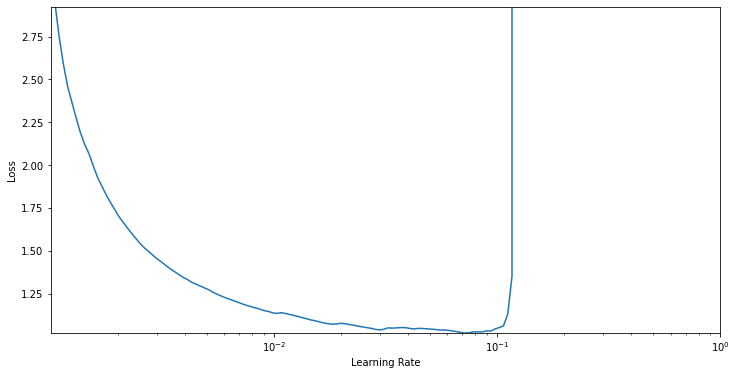

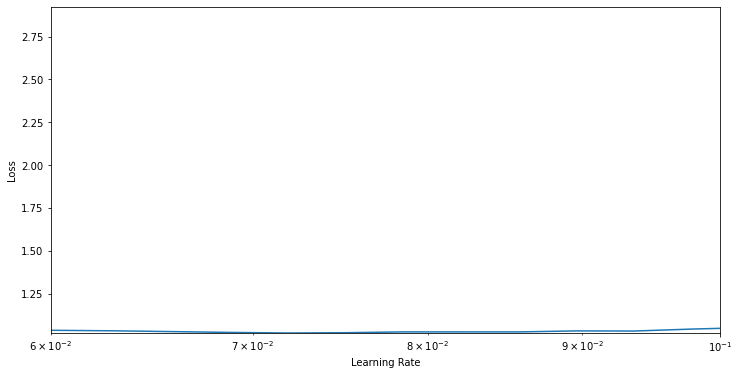

In [61]:
plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(min(increase_lr_cb.rates), 1)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()


plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(0.06, 0.1)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()

## 1cycle Max Learning Rate

We see from the above plot that loss starts increasing after 0.08 learning rate. Thus, we use 0.075 as the maximum learning rate for 1cycle schedule.



## Experiment 2(a) Weight Initialization by Pretraining (Orthogonal Initializer)

In [62]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

model_pretrained = Sequential()
model_pretrained.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model_pretrained.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained.add(MaxPooling2D((2, 2)))
model_pretrained.add(Dropout(0.2))

model_pretrained.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained.add(MaxPooling2D((2, 2)))
model_pretrained.add(Dropout(0.3))

model_pretrained.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained.add(MaxPooling2D((2, 2)))
model_pretrained.add(Dropout(0.4))

model_pretrained.add(Flatten())
model_pretrained.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model_pretrained.add(Dropout(0.5))
model_pretrained.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


'''
Compile the model
'''
model_pretrained.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


loss_history_oneCycle_cb = LossHistory_OneCycle()


model_name = "CIFAR10_CNN_Pretraining_1cycle_Orthogonal"
model_name_format = "CIFAR10_CNN_Pretraining_1cycle_Orthogonal.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)



no_of_epochs = 10
size_of_mini_batch = 32
no_iterations = (len(X_train_small) // size_of_mini_batch) * no_of_epochs


lschedule_oneCycle_cb = OneCycle(no_iterations, max_rate=0.075, momentum_vals=(0.95, 0.85))


t0 = time.time()
history_Pretraining_1cycle_Orthogonal = model_pretrained.fit(X_train_small, y_train_small, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid_small, y_valid_small),
                    callbacks=[tensorboard_cb, checkpoint_cb, lschedule_oneCycle_cb,
                               loss_history_oneCycle_cb])
t1 = time.time()

duration_Pretraining_1cycle_Orthogonal_sec = t1-t0
duration_Pretraining_1cycle_Orthogonal = convertTime(t1 - t0)
print("\nTraining Time: ", duration_Pretraining_1cycle_Orthogonal)
print("\n")


model_pretrained.save(model_name_format)

Epoch 1/10
283/283 [==============================] - 6s 20ms/step - loss: 0.6246 - accuracy: 0.7003 - val_loss: 0.3446 - val_accuracy: 0.8601
Epoch 2/10
283/283 [==============================] - 5s 19ms/step - loss: 0.3919 - accuracy: 0.8336 - val_loss: 0.2643 - val_accuracy: 0.8995
Epoch 3/10
283/283 [==============================] - 5s 18ms/step - loss: 0.2902 - accuracy: 0.8805 - val_loss: 0.3710 - val_accuracy: 0.8435
Epoch 4/10
283/283 [==============================] - 5s 18ms/step - loss: 0.2344 - accuracy: 0.9053 - val_loss: 0.1744 - val_accuracy: 0.9295
Epoch 5/10
283/283 [==============================] - 5s 19ms/step - loss: 0.2017 - accuracy: 0.9200 - val_loss: 0.1530 - val_accuracy: 0.9347
Epoch 6/10
283/283 [==============================] - 5s 19ms/step - loss: 0.1530 - accuracy: 0.9440 - val_loss: 0.1300 - val_accuracy: 0.9513
Epoch 7/10
283/283 [==============================] - 5s 19ms/step - loss: 0.1237 - accuracy: 0.9516 - val_loss: 0.1200 - val_accuracy: 0.9544

## Experiment 2(a): Transfer Pretrained Weights (Except Last Two Hidden Layers & Final Layer)

In [63]:
#model_pretrained = keras.models.load_model("CIFAR10_CNN_Pretraining_1cycle_Orthogonal.h5")

'''
We keep a copy of the pretrained model.
'''
model_pretrained_clone_Orthogonal = keras.models.clone_model(model_pretrained)
model_pretrained_clone_Orthogonal.set_weights(model_pretrained.get_weights())

print("No. of Pretrained Layers: ", len(model_pretrained.layers))

model_pretrained_clone_Orthogonal.summary()

'''
Create a new model using the pretrained model without the last two hidden layers ad the final layer.
Then, add two hidden layers followed by the final layer.
'''

model = keras.models.Sequential(model_pretrained.layers[0:8])

print("No. of Transfered Layers: ", len(model.layers))


model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))


model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

No. of Pretrained Layers:  16
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPoolin

## Experiment 2(a): Fine-Tune the Pretrained Model with Full Training Data

In [64]:

'''
Define the optimizer
'''
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


loss_history_oneCycle_cb = LossHistory_OneCycle()


model_name = "CIFAR10_CNN_FineTuning_1cycle_Orthogonal"
model_name_format = "CIFAR10_CNN_FineTuning_1cycle_Orthogonal.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)



no_of_epochs = 100
size_of_mini_batch = 64
no_iterations = (len(X_train) // size_of_mini_batch) * no_of_epochs


lschedule_oneCycle_cb = OneCycle(no_iterations, max_rate=0.075, momentum_vals=(0.95, 0.85))


t0 = time.time()
history_CNN_FineTuning_1cycle_Orthogonal = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, lschedule_oneCycle_cb, loss_history_oneCycle_cb])
t1 = time.time()

duration_CNN_FineTuning_1cycle_Orthogonal_sec = t1-t0
duration_CNN_FineTuning_1cycle_Orthogonal = convertTime(duration_CNN_FineTuning_1cycle_Orthogonal_sec)
print("\nTraining Time: ", duration_CNN_FineTuning_1cycle_Orthogonal)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 18s 26ms/step - loss: 1.6905 - accuracy: 0.3876 - val_loss: 1.5948 - val_accuracy: 0.4188
Epoch 2/100
704/704 [==============================] - 18s 26ms/step - loss: 1.3489 - accuracy: 0.5197 - val_loss: 1.2182 - val_accuracy: 0.5594
Epoch 3/100
704/704 [==============================] - 18s 26ms/step - loss: 1.2240 - accuracy: 0.5656 - val_loss: 1.0846 - val_accuracy: 0.6242
Epoch 4/100
704/704 [==============================] - 19s 26ms/step - loss: 1.1454 - accuracy: 0.5964 - val_loss: 1.1676 - val_accuracy: 0.5912
Epoch 5/100
704/704 [==============================] - 18s 26ms/step - loss: 1.0780 - accuracy: 0.6212 - val_loss: 1.0328 - val_accuracy: 0.6456
Epoch 6/100
704/704 [==============================] - 18s 26ms/step - loss: 1.0334 - accuracy: 0.6378 - val_loss: 0.8827 - val_accuracy: 0.6906
Epoch 7/100
704/704 [==============================] - 18s 26ms/step - loss: 0.9797 - accuracy: 0.6553 - val_loss: 3.2359 - val_ac

Epochs:  100

CIFAR10_CNN_FineTuning_1cycle_Orthogonal Test Accuracy: 0.866
CIFAR10_CNN_FineTuning_1cycle_Orthogonal Test Loss: 0.563

Test Confusion Matrix:
[[858   6  29  15   9   4   3   9  43  24]
 [  5 925   0   0   2   2   3   0  14  49]
 [ 35   0 785  26  52  38  44  11   6   3]
 [  7   2  32 700  52 132  42  16   7  10]
 [  3   1  27  18 887  17  20  25   2   0]
 [  8   0  24  78  27 830  12  18   2   1]
 [  4   0  15  25  16   6 926   5   1   2]
 [  6   0  12  18  37  28   1 892   1   5]
 [ 22   7   5   4   2   2   2   2 940  14]
 [  9  43   2   4   1   0   4   4  12 921]]


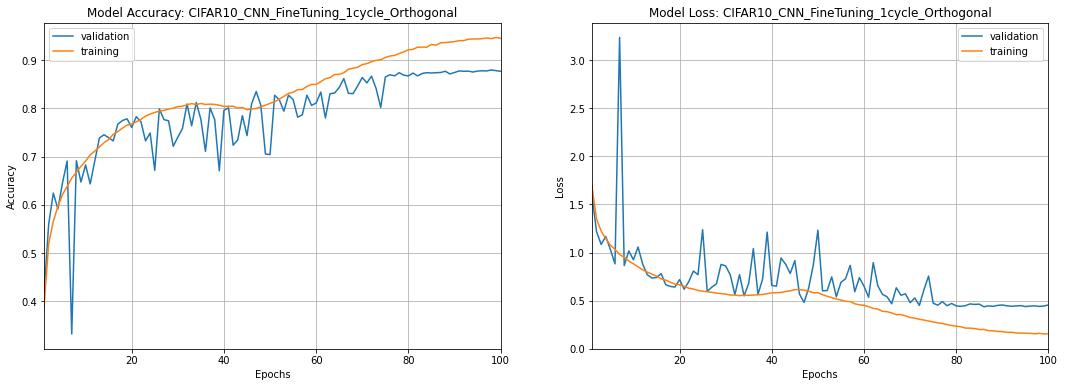

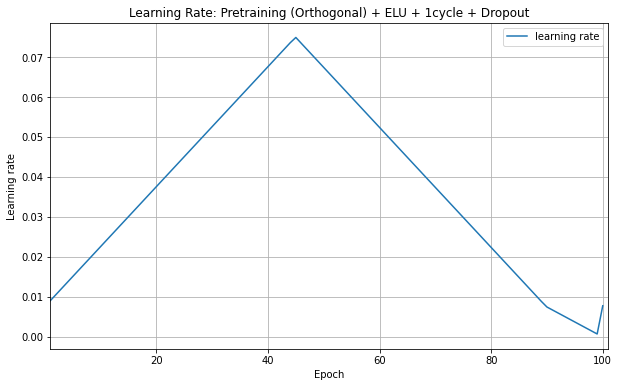

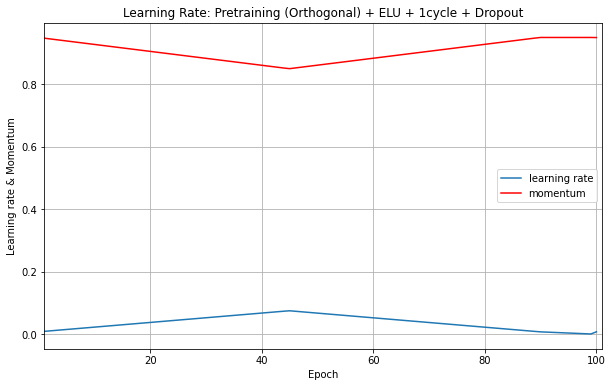

In [65]:
# Load the saved model for making predictions
#model = keras.models.load_model("CIFAR10_CNN_FineTuning_1cycle_Orthogonal.h5")

numOfEpochs_CNN_FineTuning_1cycle_Orthogonal = len(history_CNN_FineTuning_1cycle_Orthogonal.history['loss'])
print("Epochs: ", numOfEpochs_CNN_FineTuning_1cycle_Orthogonal)

test_loss_CNN_FineTuning_1cycle_Orthogonal, test_accuracy_CNN_FineTuning_1cycle_Orthogonal = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_CNN_FineTuning_1cycle_Orthogonal))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_CNN_FineTuning_1cycle_Orthogonal))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_CNN_FineTuning_1cycle_Orthogonal, numOfEpochs_CNN_FineTuning_1cycle_Orthogonal, 
                     model_name)

plot_learning_rate(loss_history_oneCycle_cb, numOfEpochs_CNN_FineTuning_1cycle_Orthogonal, 
                   "Learning Rate: Pretraining (Orthogonal) + ELU + 1cycle + Dropout", momentumPlot=False)


plot_learning_rate(loss_history_oneCycle_cb, numOfEpochs_CNN_FineTuning_1cycle_Orthogonal, 
                   "Learning Rate: Pretraining (Orthogonal) + ELU + 1cycle + Dropout", momentumPlot=True)

## Experiment 2(b): Weight Initialization by Pretraining using He Initializer

#### Find Maximum Learning Rate for 1cycle Schedule

In [66]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

initializer = 'he_normal'
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



# Define the optimizer
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

'''
Create an IncreaseLearningRate object.
It increases the learning rate by 0.5% at each iteration:
We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration.
'''
size_mini_batch = 64
no_of_epochs = 1
upper_bound_lr = 0.5
lower_bound_lr = 1e-3
increase_factor = computeFactorForIncreasingLearningRate(X_train_small, size_mini_batch, no_of_epochs, 
                                                         upper_bound_lr, lower_bound_lr)
increase_lr_cb = IncreaseLearningRate(factor=increase_factor)

'''
Train the model
'''
model.fit(X_train_small, y_train_small, 
                    batch_size=size_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid_small, y_valid_small),
                    callbacks=[increase_lr_cb])

142/142 [==============================] - 4s 26ms/step - loss: nan - accuracy: 0.5146 - val_loss: nan - val_accuracy: 0.5233
CPU times: user 3.47 s, sys: 637 ms, total: 4.11 s
Wall time: 4.6 s


## Experiment 2(b): Loss vs Learning Rate Plot

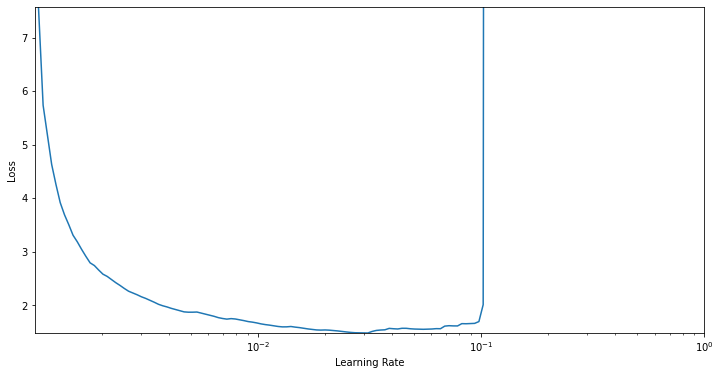

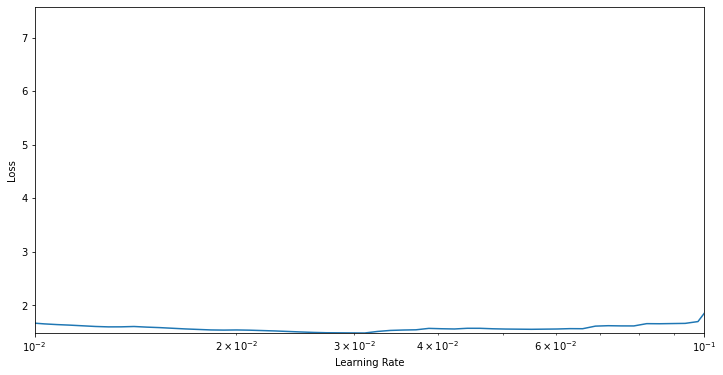

In [67]:
plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(min(increase_lr_cb.rates), 1)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()


plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(0.01, 0.1)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()

## Experiment 2(b): 1cycle Max Learning Rate

We see from the above plot that loss starts increasing after 0.03 learning rate. Thus, we use 0.03 as the maximum learning rate for 1cycle schedule.




## Experiment 2(b) Weight Initialization by Pretraining (He Initializer)

In [68]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

initializer = 'he_normal'

model_pretrained_He = Sequential()
model_pretrained_He.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model_pretrained_He.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained_He.add(MaxPooling2D((2, 2)))
model_pretrained_He.add(Dropout(0.2))

model_pretrained_He.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained_He.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained_He.add(MaxPooling2D((2, 2)))
model_pretrained_He.add(Dropout(0.3))

model_pretrained_He.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained_He.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained_He.add(MaxPooling2D((2, 2)))
model_pretrained_He.add(Dropout(0.4))

model_pretrained_He.add(Flatten())
model_pretrained_He.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model_pretrained_He.add(Dropout(0.5))
model_pretrained_He.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


'''
Compile the model
'''
model_pretrained_He.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


loss_history_oneCycle_cb = LossHistory_OneCycle()


model_name = "CIFAR10_CNN_Pretraining_1cycle_He"
model_name_format = "CIFAR10_CNN_Pretraining_1cycle_He.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)


'''
Create early stopping callback.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=20, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)


no_of_epochs = 10
size_of_mini_batch = 32
no_iterations = (len(X_train_small) // size_of_mini_batch) * no_of_epochs


lschedule_oneCycle_cb = OneCycle(no_iterations, max_rate=0.03, momentum_vals=(0.95, 0.85))


t0 = time.time()
history_Pretraining_1cycle_He = model_pretrained_He.fit(X_train_small, y_train_small, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid_small, y_valid_small),
                    callbacks=[tensorboard_cb, checkpoint_cb, lschedule_oneCycle_cb,
                               early_stopping_cb, loss_history_oneCycle_cb])
t1 = time.time()

duration_Pretraining_1cycle_He_sec = t1-t0
duration_Pretraining_1cycle_He = convertTime(t1 - t0)
print("\nTraining Time: ", duration_Pretraining_1cycle_He)
print("\n")


model_pretrained_He.save(model_name_format)

Epoch 1/10
283/283 [==============================] - 5s 19ms/step - loss: 0.7986 - accuracy: 0.6905 - val_loss: 0.3928 - val_accuracy: 0.8415
Epoch 2/10
283/283 [==============================] - 5s 18ms/step - loss: 0.4550 - accuracy: 0.8013 - val_loss: 0.2633 - val_accuracy: 0.8839
Epoch 3/10
283/283 [==============================] - 5s 18ms/step - loss: 0.3499 - accuracy: 0.8525 - val_loss: 0.2639 - val_accuracy: 0.8860
Epoch 4/10
283/283 [==============================] - 5s 19ms/step - loss: 0.2955 - accuracy: 0.8792 - val_loss: 0.2093 - val_accuracy: 0.9140
Epoch 5/10
283/283 [==============================] - 5s 19ms/step - loss: 0.2472 - accuracy: 0.9020 - val_loss: 0.1649 - val_accuracy: 0.9409
Epoch 6/10
283/283 [==============================] - 5s 19ms/step - loss: 0.1983 - accuracy: 0.9223 - val_loss: 0.1643 - val_accuracy: 0.9337
Epoch 7/10
283/283 [==============================] - 5s 18ms/step - loss: 0.1747 - accuracy: 0.9314 - val_loss: 0.1510 - val_accuracy: 0.9409

## Experiment 2(b): Transfer Pretrained Weights (Except Last Two Hidden Layers & Final Layer)

In [69]:
#model_pretrained = keras.models.load_model("CIFAR10_CNN_Pretraining_1cycle_He.h5")

'''
We keep a copy of the pretrained model.
'''
model_pretrained_clone_He = keras.models.clone_model(model_pretrained_He)
model_pretrained_clone_He.set_weights(model_pretrained_He.get_weights())

print("No. of Pretrained Layers: ", len(model_pretrained_He.layers))

model_pretrained_clone_He.summary()

'''
Create a new model using the pretrained model without the last two hidden layers ad the final layer.
Then, add two hidden layers followed by the final layer.
'''

model = keras.models.Sequential(model_pretrained_He.layers[0:8])

print("No. of Transfered Layers: ", len(model.layers))


initializer = 'he_normal'


model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))


model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

No. of Pretrained Layers:  16
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPoolin

## Experiment 2(b): Fine-Tune the Pretrained Model with Full Training Data

In [70]:

'''
Define the optimizer
'''
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


loss_history_oneCycle_cb = LossHistory_OneCycle()


model_name = "CIFAR10_CNN_FineTuning_1cycle_He"
model_name_format = "CIFAR10_CNN_FineTuning_1cycle_He.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)


'''
Create early stopping callback.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=20, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)


no_of_epochs = 100
size_of_mini_batch = 64
no_iterations = (len(X_train) // size_of_mini_batch) * no_of_epochs


lschedule_oneCycle_cb = OneCycle(no_iterations, max_rate=0.03, momentum_vals=(0.95, 0.85))


t0 = time.time()
history_CNN_FineTuning_1cycle_He = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, lschedule_oneCycle_cb, loss_history_oneCycle_cb])
t1 = time.time()

duration_CNN_FineTuning_1cycle_He_sec = t1-t0
duration_CNN_FineTuning_1cycle_He = convertTime(duration_CNN_FineTuning_1cycle_He_sec)
print("\nTraining Time: ", duration_CNN_FineTuning_1cycle_He)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 19s 26ms/step - loss: 2.1492 - accuracy: 0.2809 - val_loss: 2.2460 - val_accuracy: 0.2482
Epoch 2/100
704/704 [==============================] - 18s 26ms/step - loss: 1.6644 - accuracy: 0.4060 - val_loss: 1.8400 - val_accuracy: 0.3616
Epoch 3/100
704/704 [==============================] - 18s 26ms/step - loss: 1.5011 - accuracy: 0.4634 - val_loss: 1.2077 - val_accuracy: 0.5732
Epoch 4/100
704/704 [==============================] - 18s 26ms/step - loss: 1.3907 - accuracy: 0.5060 - val_loss: 1.4120 - val_accuracy: 0.4952
Epoch 5/100
704/704 [==============================] - 18s 26ms/step - loss: 1.3019 - accuracy: 0.5370 - val_loss: 1.3185 - val_accuracy: 0.5364
Epoch 6/100
704/704 [==============================] - 18s 26ms/step - loss: 1.2316 - accuracy: 0.5638 - val_loss: 1.1452 - val_accuracy: 0.5878
Epoch 7/100
704/704 [==============================] - 19s 27ms/step - loss: 1.1867 - accuracy: 0.5802 - val_loss: 2.3816 - val_ac

Epochs:  100

CIFAR10_CNN_FineTuning_1cycle_He Test Accuracy: 0.854
CIFAR10_CNN_FineTuning_1cycle_He Test Loss: 0.486

Test Confusion Matrix:
[[855   8  29  15  16   1   6   6  42  22]
 [  4 927   1   2   1   0   4   0  12  49]
 [ 46   0 770  27  57  48  36  11   4   1]
 [ 12   1  46 711  46 109  46  18   5   6]
 [  9   1  31  24 869  21  19  21   3   2]
 [  4   1  26 107  38 786  12  24   1   1]
 [  2   3  27  26  15   6 912   6   1   2]
 [  7   1  14  20  34  38   4 875   0   7]
 [ 32  10   2   2   3   2   3   2 929  15]
 [ 12  40   2   3   4   3   3   3  22 908]]


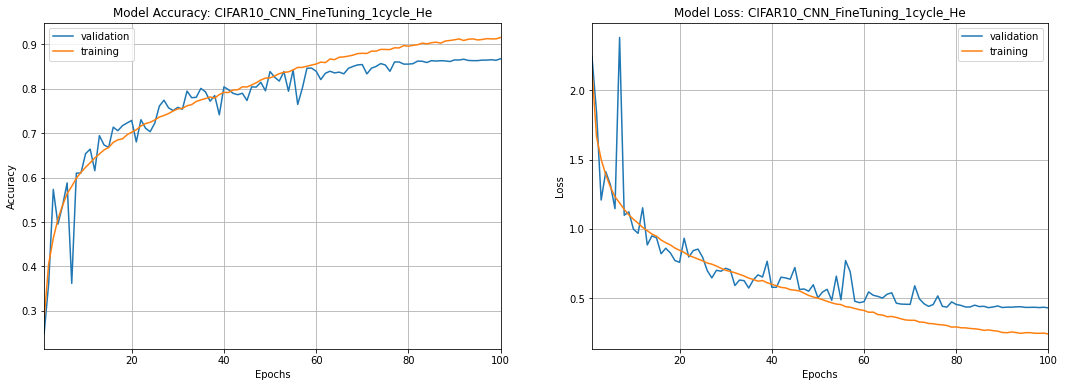

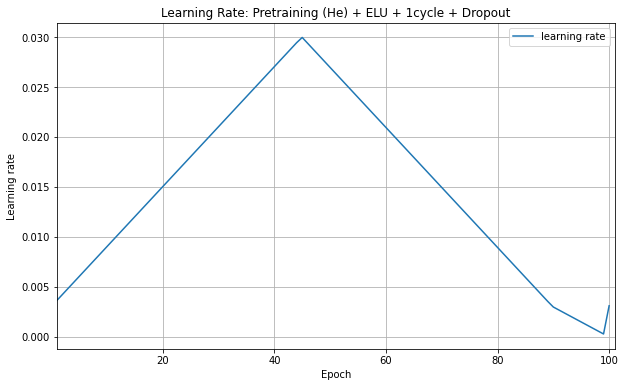

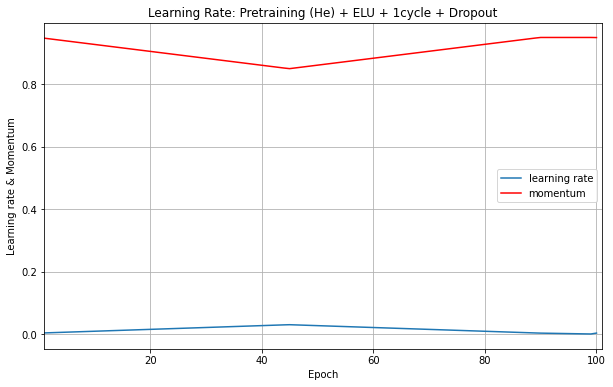

In [71]:
# Load the saved model for making predictions
#model = keras.models.load_model("CIFAR10_CNN_FineTuning_1cycle_He.h5")

numOfEpochs_CNN_FineTuning_1cycle_He = len(history_CNN_FineTuning_1cycle_He.history['loss'])
print("Epochs: ", numOfEpochs_CNN_FineTuning_1cycle_He)

test_loss_CNN_FineTuning_1cycle_He, test_accuracy_CNN_FineTuning_1cycle_He = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_CNN_FineTuning_1cycle_He))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_CNN_FineTuning_1cycle_He))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_CNN_FineTuning_1cycle_He, numOfEpochs_CNN_FineTuning_1cycle_He, 
                     model_name)

plot_learning_rate(loss_history_oneCycle_cb, numOfEpochs_CNN_FineTuning_1cycle_He, 
                   "Learning Rate: Pretraining (He) + ELU + 1cycle + Dropout", momentumPlot=False)


plot_learning_rate(loss_history_oneCycle_cb, numOfEpochs_CNN_FineTuning_1cycle_He, 
                   "Learning Rate: Pretraining (He) + ELU + 1cycle + Dropout", momentumPlot=True)

## Experiment 3 (a): Orthogonal Initializer + ELU Activation + 1cycle Learning Schedule

#### Find Maximum Learning Rate for 1cycle Schedule

In [76]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''
orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
initializer = orthogonal_init
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



# Define the optimizer
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

'''
Create an IncreaseLearningRate object.
It increases the learning rate by 0.5% at each iteration:
We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration.
'''
size_mini_batch = 64
no_of_epochs = 1
upper_bound_lr = 0.5
lower_bound_lr = 1e-3
increase_factor = computeFactorForIncreasingLearningRate(X_train, size_mini_batch, no_of_epochs, 
                                                         upper_bound_lr, lower_bound_lr)
increase_lr_cb = IncreaseLearningRate(factor=increase_factor)

'''
Train the model
'''
model.fit(X_train, y_train, 
                    batch_size=size_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[increase_lr_cb])

704/704 [==============================] - 18s 25ms/step - loss: nan - accuracy: 0.1780 - val_loss: nan - val_accuracy: 0.1010
CPU times: user 13.3 s, sys: 3.52 s, total: 16.9 s
Wall time: 19.4 s


## Experiment 3: Loss vs Learning Rate Plot

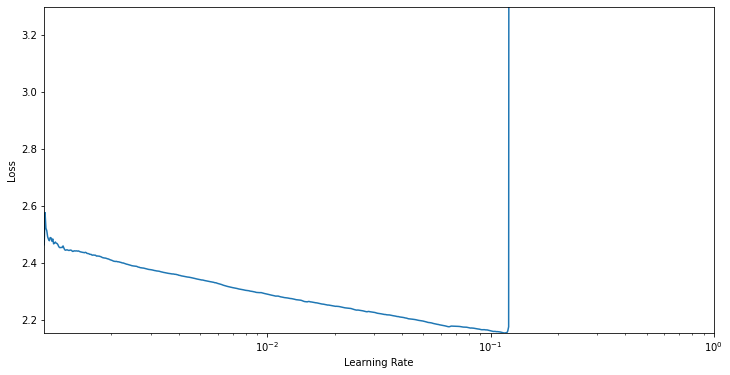

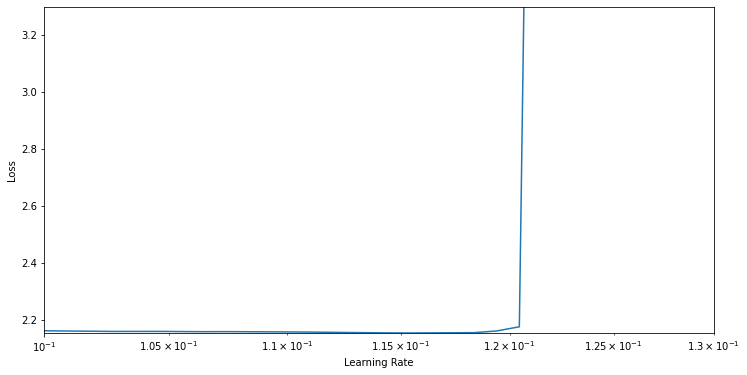

In [77]:
plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(min(increase_lr_cb.rates), 1)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()


plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(0.1, 0.13)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()

## Experiment 3 (a): 1cycle Max Learning Rate
We see from the above plot that loss starts increasing after 0.12 learning rate. To avoid overshooting, We use 0.08 as the maximum learning rate for 1cycle schedule.

## Experiment 3 (a): Train the CNN using 1cycle Learning Schedule

In [78]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
initializer = orthogonal_init
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

loss_history_oneCycle_cb = LossHistory_OneCycle()


model_name = "CIFAR10_CNN_Orthogonal_1cycle"
model_name_format = "CIFAR10_CNN_Orthogonal_1cycle.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)



no_of_epochs = 100
size_of_mini_batch = 64
no_iterations = (len(X_train) // size_of_mini_batch) * no_of_epochs


lschedule_oneCycle_cb = OneCycle(no_iterations, max_rate=0.08, momentum_vals=(0.95, 0.85))


t0 = time.time()
history_CNN_Orthogonal_1cycle = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, lschedule_oneCycle_cb, loss_history_oneCycle_cb])
t1 = time.time()

duration_CNN_Orthogonal_1cycle_sec = t1-t0
duration_CNN_Orthogonal_1cycle = convertTime(t1 - t0)
print("\nTraining Time: ", duration_CNN_Orthogonal_1cycle)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 19s 26ms/step - loss: 1.9551 - accuracy: 0.2803 - val_loss: 2.0871 - val_accuracy: 0.2572
Epoch 2/100
704/704 [==============================] - 18s 26ms/step - loss: 1.6556 - accuracy: 0.3971 - val_loss: 1.5538 - val_accuracy: 0.4262
Epoch 3/100
704/704 [==============================] - 18s 26ms/step - loss: 1.4795 - accuracy: 0.4659 - val_loss: 1.4392 - val_accuracy: 0.4882
Epoch 4/100
704/704 [==============================] - 18s 26ms/step - loss: 1.3397 - accuracy: 0.5205 - val_loss: 1.2708 - val_accuracy: 0.5478
Epoch 5/100
704/704 [==============================] - 18s 26ms/step - loss: 1.2230 - accuracy: 0.5649 - val_loss: 1.0513 - val_accuracy: 0.6356
Epoch 6/100
704/704 [==============================] - 19s 26ms/step - loss: 1.1385 - accuracy: 0.6014 - val_loss: 1.0571 - val_accuracy: 0.6236
Epoch 7/100
704/704 [==============================] - 18s 26ms/step - loss: 1.0749 - accuracy: 0.6219 - val_loss: 3.0850 - val_ac

Epochs:  100

CIFAR10_CNN_Orthogonal_1cycle Test Accuracy: 0.864
CIFAR10_CNN_Orthogonal_1cycle Test Loss: 0.535

Test Confusion Matrix:
[[852   4  29  10  19   1   6   7  39  33]
 [  5 900   0   4   1   1   3   0  15  71]
 [ 34   0 783  32  54  45  32  14   4   2]
 [  9   1  27 707  48 137  40   9  10  12]
 [  6   1  24  20 892  19   9  26   3   0]
 [  4   0  17  93  25 830  10  19   0   2]
 [  4   1  12  31  19   9 914   5   2   3]
 [  5   1   8  19  23  53   3 882   0   6]
 [ 27   1   3   7   5   2   2   1 927  25]
 [  9   9   2   6   2   1   1   2  15 953]]


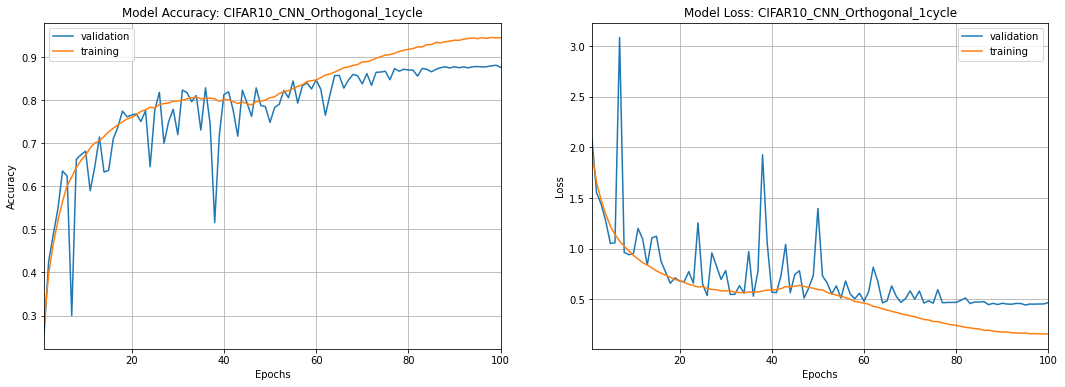

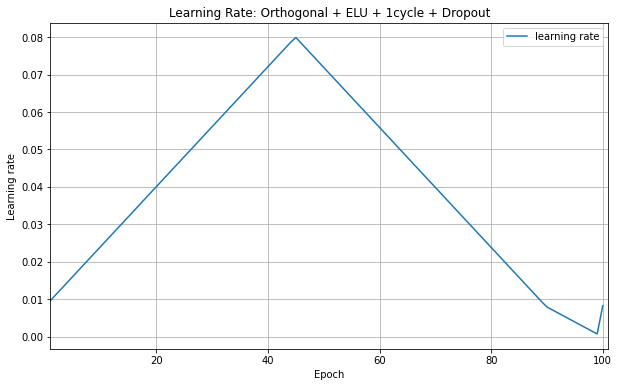

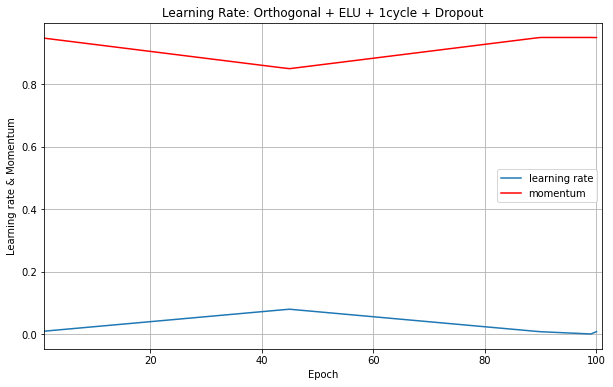

In [79]:
# Load the saved model for making predictions
#model = keras.models.load_model("CIFAR10_CNN_Orthogonal_1cycle.h5")

numOfEpochs_CNN_Orthogonal_1cycle = len(history_CNN_Orthogonal_1cycle.history['loss'])
print("Epochs: ", numOfEpochs_CNN_Orthogonal_1cycle)

test_loss_CNN_Orthogonal_1cycle, test_accuracy_CNN_Orthogonal_1cycle = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_CNN_Orthogonal_1cycle))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_CNN_Orthogonal_1cycle))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_CNN_Orthogonal_1cycle, numOfEpochs_CNN_Orthogonal_1cycle, 
                     model_name)

plot_learning_rate(loss_history_oneCycle_cb, numOfEpochs_CNN_Orthogonal_1cycle, 
                   "Learning Rate: Orthogonal + ELU + 1cycle + Dropout", momentumPlot=False)


plot_learning_rate(loss_history_oneCycle_cb, numOfEpochs_CNN_Orthogonal_1cycle, 
                   "Learning Rate: Orthogonal + ELU + 1cycle + Dropout", momentumPlot=True)

## Experiment 3(b): Orthogonal + ELU + NAdam (0.001)

In this experiment we only replace the 1cycle schedule on the previous experiment with the NAdam optimizer.

In [80]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
initializer = orthogonal_init
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.Nadam(learning_rate=1e-3)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

loss_history_cb = LossHistory()


model_name = "CIFAR10_CNN_Orthogonal_Nadam"
model_name_format = "CIFAR10_CNN_Orthogonal_Nadam.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)



no_of_epochs = 100
size_of_mini_batch = 64



t0 = time.time()
history_CNN_Orthogonal_Nadam = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, loss_history_cb])
t1 = time.time()

duration_CNN_Orthogonal_Nadam_sec = t1-t0
duration_CNN_Orthogonal_Nadam = convertTime(t1 - t0)
print("\nTraining Time: ", duration_CNN_Orthogonal_Nadam)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 22s 31ms/step - loss: 1.5353 - accuracy: 0.4535 - val_loss: 1.1698 - val_accuracy: 0.5956
Epoch 2/100
704/704 [==============================] - 21s 30ms/step - loss: 1.1570 - accuracy: 0.5969 - val_loss: 1.1882 - val_accuracy: 0.5940
Epoch 3/100
704/704 [==============================] - 22s 31ms/step - loss: 1.0296 - accuracy: 0.6415 - val_loss: 1.1263 - val_accuracy: 0.6090
Epoch 4/100
704/704 [==============================] - 21s 31ms/step - loss: 0.9688 - accuracy: 0.6632 - val_loss: 0.8204 - val_accuracy: 0.7164
Epoch 5/100
704/704 [==============================] - 22s 31ms/step - loss: 0.9081 - accuracy: 0.6829 - val_loss: 0.8113 - val_accuracy: 0.7278
Epoch 6/100
704/704 [==============================] - 21s 30ms/step - loss: 0.8805 - accuracy: 0.6932 - val_loss: 0.7091 - val_accuracy: 0.7534
Epoch 7/100
704/704 [==============================] - 21s 30ms/step - loss: 0.8513 - accuracy: 0.7078 - val_loss: 1.2337 - val_ac

Epochs:  100

CIFAR10_CNN_Orthogonal_Nadam Test Accuracy: 0.831
CIFAR10_CNN_Orthogonal_Nadam Test Loss: 0.655

Test Confusion Matrix:
[[851   7   9  38   1   1   3   6  47  37]
 [  7 907   1   8   3   0   2   0   9  63]
 [ 64   3 676  68  63  55  44  14   9   4]
 [  8   2  21 765  28  94  55  12   7   8]
 [ 16   2  17  49 806  28  37  38   7   0]
 [  2   0   7 183  21 739  21  23   3   1]
 [  5   1  12  48  12   7 908   1   5   1]
 [ 12   0   6  75  20  43   4 835   1   4]
 [ 40   9   3  16   0   1   5   0 908  18]
 [  9  29   1  16   0   4   4   8  16 913]]


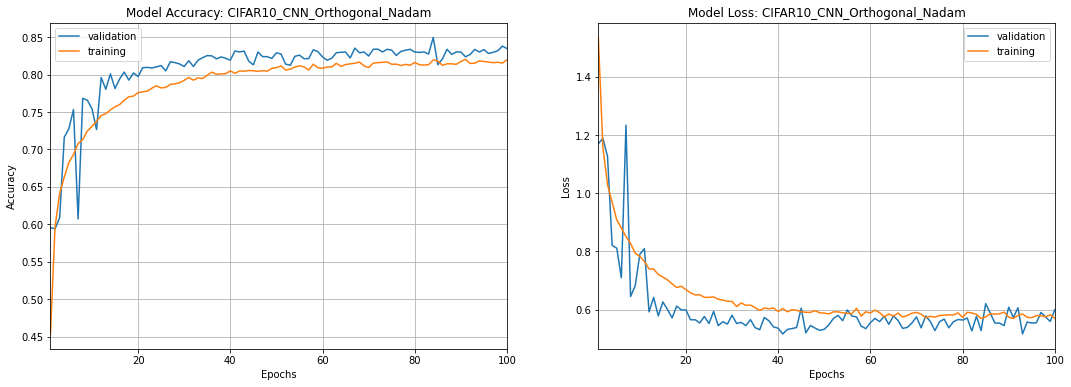

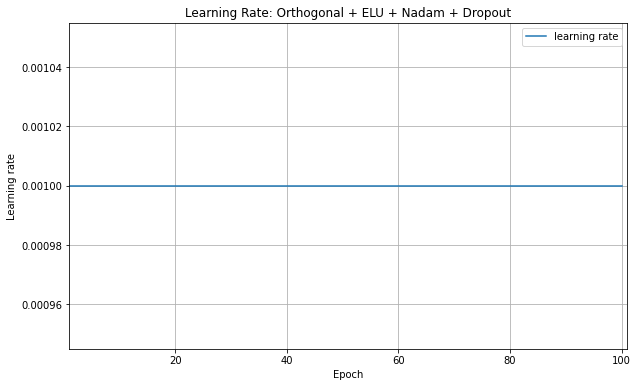

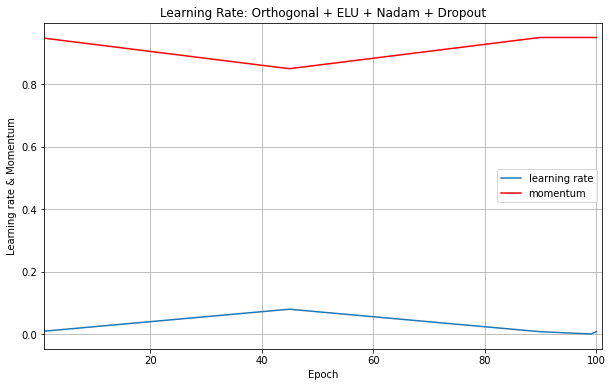

In [82]:
# Load the saved model for making predictions
#model = keras.models.load_model("CIFAR10_CNN_Orthogonal_Nadam.h5")

numOfEpochs_CNN_Orthogonal_Nadam = len(history_CNN_Orthogonal_Nadam.history['loss'])
print("Epochs: ", numOfEpochs_CNN_Orthogonal_1cycle)

test_loss_CNN_Orthogonal_Nadam, test_accuracy_CNN_Orthogonal_Nadam = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_CNN_Orthogonal_Nadam))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_CNN_Orthogonal_Nadam))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_CNN_Orthogonal_Nadam, numOfEpochs_CNN_Orthogonal_Nadam, 
                     model_name)

plot_learning_rate(loss_history_cb, numOfEpochs_CNN_Orthogonal_Nadam, 
                   "Learning Rate: Orthogonal + ELU + Nadam + Dropout", momentumPlot=False)


plot_learning_rate(loss_history_oneCycle_cb, numOfEpochs_CNN_Orthogonal_1cycle, 
                   "Learning Rate: Orthogonal + ELU + Nadam + Dropout", momentumPlot=True)

## Experiment 4: He Initializer + ELU Activation + 1cycle Learning Schedule

#### Find Maximum Learning Rate for 1cycle Schedule

In [83]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''
initializer = 'he_normal'
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



# Define the optimizer
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

'''
Create an IncreaseLearningRate object.
It increases the learning rate by 0.5% at each iteration:
We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration.
'''
size_mini_batch = 64
no_of_epochs = 1
upper_bound_lr = 0.5
lower_bound_lr = 1e-3
increase_factor = computeFactorForIncreasingLearningRate(X_train, size_mini_batch, no_of_epochs, 
                                                         upper_bound_lr, lower_bound_lr)
increase_lr_cb = IncreaseLearningRate(factor=increase_factor)

'''
Train the model
'''
model.fit(X_train, y_train, 
                    batch_size=size_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[increase_lr_cb])

704/704 [==============================] - 18s 26ms/step - loss: nan - accuracy: 0.1793 - val_loss: nan - val_accuracy: 0.1010
CPU times: user 13.7 s, sys: 3.02 s, total: 16.7 s
Wall time: 19.2 s


## Experiment 4: Loss vs Learning Rate Plot

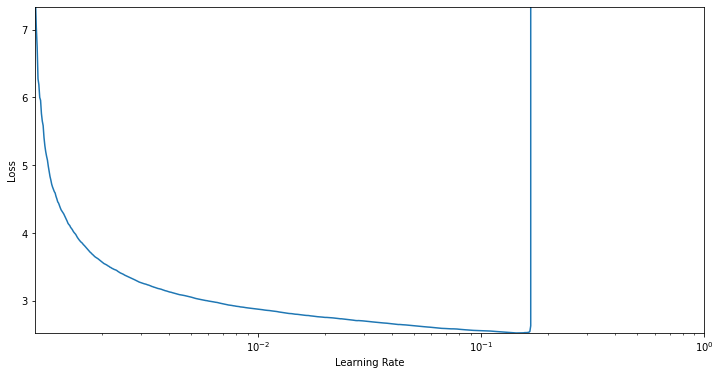

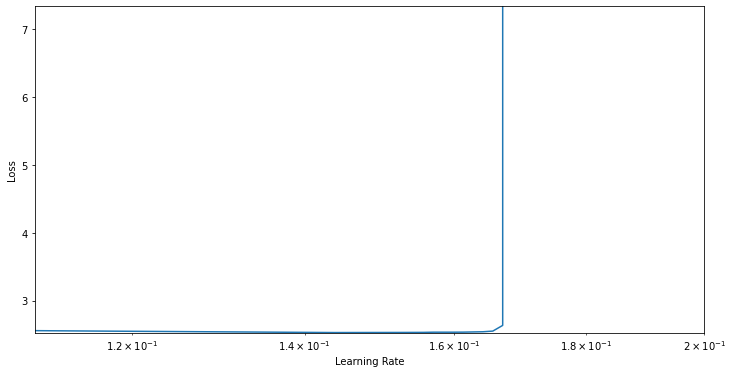

In [84]:
plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(min(increase_lr_cb.rates), 1)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()

'''
For clarity we zoom in to a smaller range
'''

plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(0.11, 0.2)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()

## Experiment 4: 1cycle Max Learning Rate
We see from the above plot that loss starts increasing after 0.16 learning rate. To avoid overshooting, We use 0.08 as the maximum learning rate for 1cycle schedule.


## Experiment 4: Train the CNN using 1cycle Learning Schedule

In [87]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

initializer = 'he_normal'
activation_func = 'elu'


model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

loss_history_oneCycle_cb = LossHistory_OneCycle()


model_name = "CIFAR10_CNN_He_1cycle"
model_name_format = "CIFAR10_CNN_He_1cycle.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)


'''
Create early stopping callback.
'''
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0, 
                                  patience=20, 
                                  verbose=1, 
                                  mode='auto',
                                  restore_best_weights=True)


no_of_epochs = 100
size_of_mini_batch = 64
no_iterations = (len(X_train) // size_of_mini_batch) * no_of_epochs


lschedule_oneCycle_cb = OneCycle(no_iterations, max_rate=0.08, momentum_vals=(0.95, 0.85))


t0 = time.time()
history_CNN_He_1cycle = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, lschedule_oneCycle_cb, loss_history_oneCycle_cb])
t1 = time.time()

duration_CNN_He_1cycle_sec = t1-t0
duration_CNN_He_1cycle = convertTime(t1 - t0)
print("\nTraining Time: ", duration_CNN_He_1cycle)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 19s 26ms/step - loss: 2.1036 - accuracy: 0.2760 - val_loss: 2.8496 - val_accuracy: 0.1948
Epoch 2/100
704/704 [==============================] - 18s 26ms/step - loss: 1.6305 - accuracy: 0.4104 - val_loss: 1.5015 - val_accuracy: 0.4486
Epoch 3/100
704/704 [==============================] - 18s 26ms/step - loss: 1.4147 - accuracy: 0.4894 - val_loss: 1.3342 - val_accuracy: 0.5426
Epoch 4/100
704/704 [==============================] - 18s 26ms/step - loss: 1.2780 - accuracy: 0.5386 - val_loss: 1.4508 - val_accuracy: 0.5076
Epoch 5/100
704/704 [==============================] - 18s 26ms/step - loss: 1.1848 - accuracy: 0.5778 - val_loss: 1.5090 - val_accuracy: 0.5136
Epoch 6/100
704/704 [==============================] - 18s 26ms/step - loss: 1.1203 - accuracy: 0.6005 - val_loss: 0.9993 - val_accuracy: 0.6432
Epoch 7/100
704/704 [==============================] - 18s 26ms/step - loss: 1.0713 - accuracy: 0.6215 - val_loss: 2.2474 - val_ac

Epochs:  100

CIFAR10_CNN_He_1cycle Test Accuracy: 0.869
CIFAR10_CNN_He_1cycle Test Loss: 0.500

Test Confusion Matrix:
[[877   5  23  11   8   3   8   8  37  20]
 [  3 938   1   1   2   3   4   0  10  38]
 [ 36   0 784  36  42  53  26  14   5   4]
 [  8   2  25 754  39 108  33  13   9   9]
 [  4   1  29  27 874  20  18  19   7   1]
 [  8   2  16 116  31 794   8  22   2   1]
 [  4   0  16  39  10  10 912   5   2   2]
 [  7   1   9  26  32  33   1 889   0   2]
 [ 23  10   3   5   2   2   2   1 938  14]
 [  8  35   2   5   2   3   2   2  10 931]]


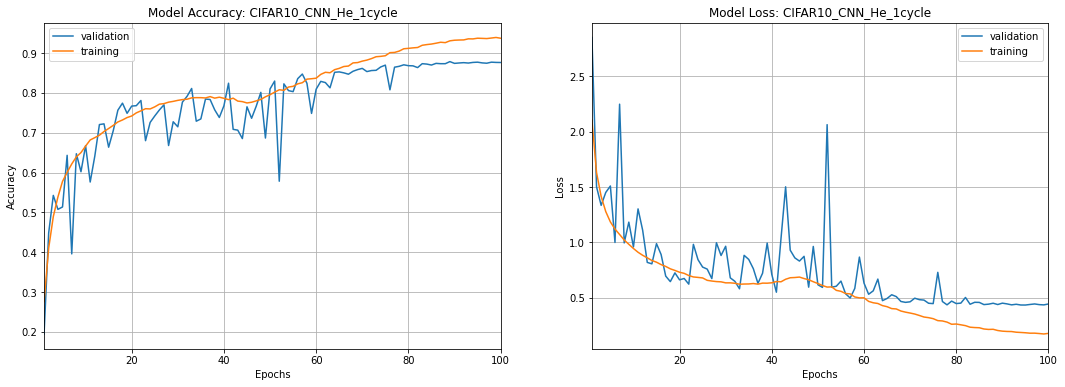

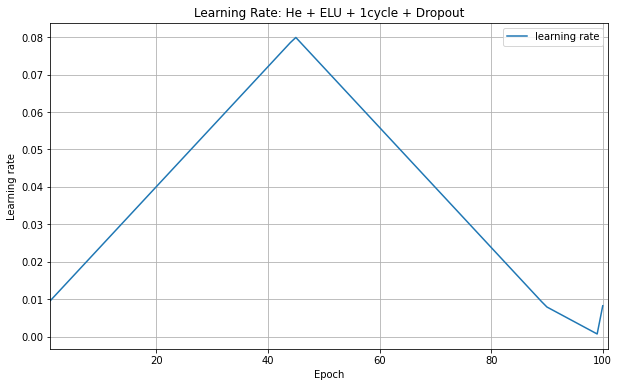

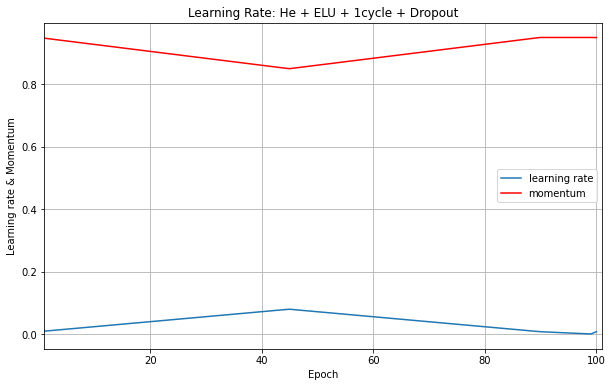

In [88]:
# Load the saved model for making predictions
#model = keras.models.load_model("CIFAR10_CNN_He_1cycle.h5")

numOfEpochs_CNN_He_1cycle = len(history_CNN_He_1cycle.history['loss'])
print("Epochs: ", numOfEpochs_CNN_He_1cycle)

test_loss_CNN_He_1cycle, test_accuracy_CNN_He_1cycle = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_CNN_He_1cycle))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_CNN_He_1cycle))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_CNN_He_1cycle, numOfEpochs_CNN_He_1cycle, 
                     model_name)

plot_learning_rate(loss_history_oneCycle_cb, numOfEpochs_CNN_He_1cycle, 
                   "Learning Rate: He + ELU + 1cycle + Dropout", momentumPlot=False)


plot_learning_rate(loss_history_oneCycle_cb, numOfEpochs_CNN_He_1cycle, 
                   "Learning Rate: He + ELU + 1cycle + Dropout", momentumPlot=True)

## Comparison of Validation Accuracy Over Epochs

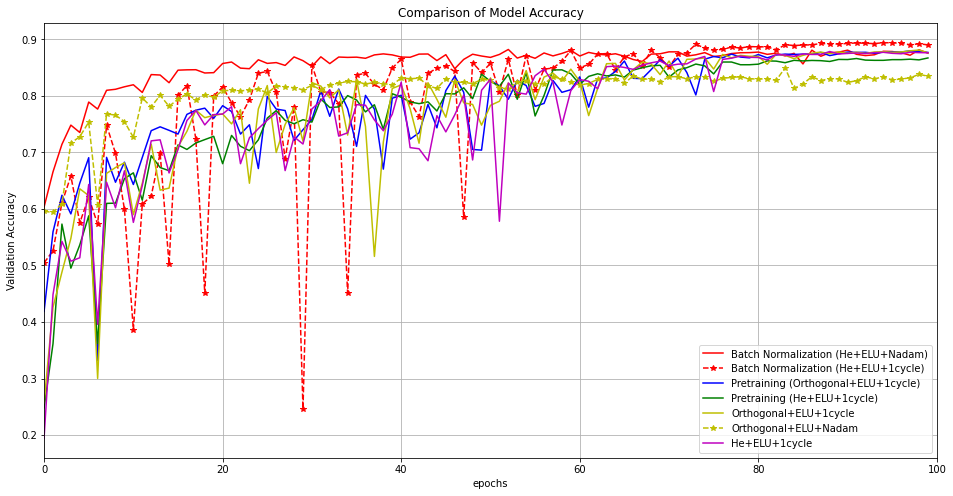

In [89]:
epochs = max(numOfEpochs_CNN_He_ELU_VarDrop_BN, numOfEpochs_CNN_FineTuning_1cycle_Orthogonal,
             numOfEpochs_CNN_FineTuning_1cycle_He, numOfEpochs_CNN_Orthogonal_1cycle,
             numOfEpochs_CNN_He_1cycle)

plt.figure(figsize=(16,8))
plt.plot(range(numOfEpochs_CNN_He_ELU_VarDrop_BN),history_CNN_He_ELU_VarDrop_BN.history['val_accuracy'],'r-',
         label='Batch Normalization (He+ELU+Nadam)')


plt.plot(range(numOfEpochs_CNN_BN_1cycle),history_CNN_BN_1cycle.history['val_accuracy'],'r*--',
         label='Batch Normalization (He+ELU+1cycle)')



plt.plot(range(numOfEpochs_CNN_FineTuning_1cycle_Orthogonal),history_CNN_FineTuning_1cycle_Orthogonal.history['val_accuracy'],'b-',
         label='Pretraining (Orthogonal+ELU+1cycle)')

plt.plot(range(numOfEpochs_CNN_FineTuning_1cycle_He),history_CNN_FineTuning_1cycle_He.history['val_accuracy'],'g-',
         label='Pretraining (He+ELU+1cycle)')

plt.plot(range(numOfEpochs_CNN_Orthogonal_1cycle),history_CNN_Orthogonal_1cycle.history['val_accuracy'],'y-',
         label='Orthogonal+ELU+1cycle')

plt.plot(range(numOfEpochs_CNN_Orthogonal_Nadam),history_CNN_Orthogonal_Nadam.history['val_accuracy'],'y*--',
         label='Orthogonal+ELU+Nadam')

plt.plot(range(numOfEpochs_CNN_He_1cycle),history_CNN_He_1cycle.history['val_accuracy'],'m-',
         label='He+ELU+1cycle')



plt.legend(loc=0)
plt.xlabel('epochs')
plt.xlim([0,epochs])
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.title("Comparison of Model Accuracy")
plt.show()


## Comparison of Test Accuracy and Total Number of Epochs

In [90]:
data = [
    ["1(a): Batch Normalization (Nadam)", numOfEpochs_CNN_He_ELU_VarDrop_BN, duration_CNN_He_ELU_VarDrop_BN, test_accuracy_CNN_He_ELU_VarDrop_BN],
    ["1(b): Batch Normalization (1cycle)", numOfEpochs_CNN_BN_1cycle, duration_CNN_BN_1cycle, test_accuracy_CNN_BN_1cycle],
    ["2(a): Pretraining (Orthogonal)", numOfEpochs_CNN_FineTuning_1cycle_Orthogonal, duration_CNN_FineTuning_1cycle_Orthogonal, 
     test_accuracy_CNN_FineTuning_1cycle_Orthogonal],
    ["2(b): Pretraining (He)", numOfEpochs_CNN_FineTuning_1cycle_He, duration_CNN_FineTuning_1cycle_He, 
     test_accuracy_CNN_FineTuning_1cycle_He],
    ["3(a): Orthogonal+ELU+1cycle", numOfEpochs_CNN_Orthogonal_1cycle, duration_CNN_Orthogonal_1cycle, 
     test_accuracy_CNN_Orthogonal_1cycle],
    ["3(b): Orthogonal+ELU+Nadam", numOfEpochs_CNN_Orthogonal_Nadam, duration_CNN_Orthogonal_Nadam, 
     test_accuracy_CNN_Orthogonal_Nadam],
    ["4: He+ELU+1cycle", numOfEpochs_CNN_He_1cycle, duration_CNN_He_1cycle, 
     test_accuracy_CNN_He_1cycle]]
pd.DataFrame(data, columns=["Experiments", "Epochs", "Training (Wall) Time", "Test Accuracy"])

,Experiments,Epochs,Training (Wall) Time,Test Accuracy
0,1(a): Batch Normalization (Nadam),100,47 min 31 s,0.8634
1,1(b): Batch Normalization (1cycle),100,37 min 4 s,0.8790
2,2(a): Pretraining (Orthogonal),100,30 min 37 s,0.8664
3,2(b): Pretraining (He),100,30 min 39 s,0.8542
4,3(a): Orthogonal+ELU+1cycle,100,30 min 37 s,0.8640
5,3(b): Orthogonal+ELU+Nadam,100,35 min 57 s,0.8308
6,4: He+ELU+1cycle,100,30 min 41 s,0.8691


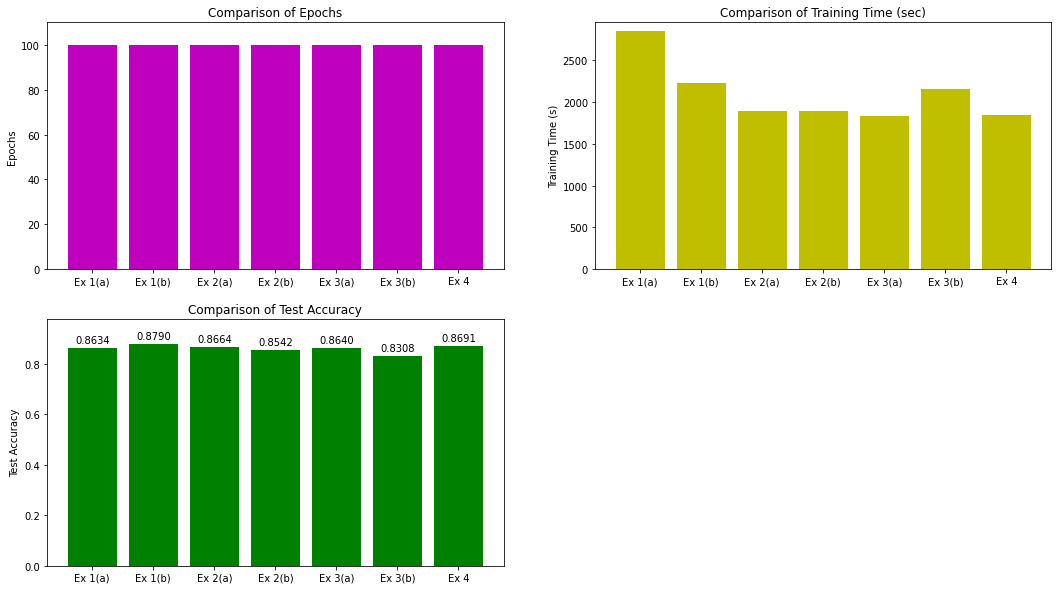

In [91]:
plt.figure(figsize=(18,10))

labels_true = ["Batch Normalization", "Pretraining (Orthogonal)", "Pretraining (He)", 
               "Orthogonal+ELU+1cycle", "He+ELU+1cycle"]


labels = ["Ex 1(a)", "Ex 1(b)", "Ex 2(a)", "Ex 2(b)", "Ex 3(a)", "Ex 3(b)", "Ex 4"]

epochs_num= [numOfEpochs_CNN_He_ELU_VarDrop_BN, numOfEpochs_CNN_BN_1cycle, numOfEpochs_CNN_FineTuning_1cycle_Orthogonal,
             numOfEpochs_CNN_FineTuning_1cycle_He, numOfEpochs_CNN_Orthogonal_1cycle,
             numOfEpochs_CNN_Orthogonal_Nadam, numOfEpochs_CNN_He_1cycle]

duration_num = [duration_CNN_He_ELU_VarDrop_BN_sec, duration_CNN_BN_1cycle_sec,
                (duration_Pretraining_1cycle_Orthogonal_sec+duration_CNN_FineTuning_1cycle_Orthogonal_sec),
                (duration_Pretraining_1cycle_He_sec+duration_CNN_FineTuning_1cycle_He_sec),
                duration_CNN_Orthogonal_1cycle_sec, duration_CNN_Orthogonal_Nadam_sec, duration_CNN_He_1cycle_sec]

test_acc = [test_accuracy_CNN_He_ELU_VarDrop_BN, test_accuracy_CNN_BN_1cycle, test_accuracy_CNN_FineTuning_1cycle_Orthogonal,
            test_accuracy_CNN_FineTuning_1cycle_He, test_accuracy_CNN_Orthogonal_1cycle,
            test_accuracy_CNN_Orthogonal_Nadam, test_accuracy_CNN_He_1cycle]


plt.subplot(221)
plt.ylabel("Epochs")
plt.title("Comparison of Epochs")
plt.ylim(0, max(epochs_num)+10)
rects1=plt.bar(labels, epochs_num, color="m")

plt.subplot(222)
plt.ylabel("Training Time (s)")
plt.title("Comparison of Training Time (sec)")
plt.ylim(0, max(duration_num)+100)
rects2=plt.bar(labels, duration_num, color="y")

plt.subplot(223)
plt.ylabel("Test Accuracy")
plt.title("Comparison of Test Accuracy")
plt.ylim(0, max(test_acc)+0.1)
rects3=plt.bar(labels, test_acc, color="g")

     
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        plt.annotate('{:.4f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects3)

plt.show()

## Comparative Analysis


Below we compare the performance of 4 approaches (with their variants) based on the results obtained from the following experiments:


- Experiment 1: Batch Normalization 
 
         -- a) He initializer + ELU activation + NAdam (lr=0.001)
         -- b) He initializer + ELU activation + 1cycle Learning Schedule

- Experiment 2: Pretraining based Weight Initialization with 1cycle Learning Schedule
 
         -- a) Orthogonal Initializer 
         -- b) He Initializer

- Experiment 3: Orthogonal Initializer + ELU activation

      -- a) 1cycle Learning Schedule
      -- b) NAdam (lr=0.001)

- Experiment 4: He Initializer + ELU activation + 1cycle Learning Schedule

We observe that overall all approaches are equally effective. The test accuracy ranges between 0.86 ~ 0.87. However, their efficiency varies.

The **Batch Normalization** based approach has the highest test accuracy, but it converges slowly due to larger training time per epoch. Using 1cycle learning schedule it can converge faster (experiment 1b). But still its training time is never smaller than that of other approaches.

The most efficient approach is the **pretraining weight initialization** approach (2a and 2b). It requires shortest training time to achieve optimal test accuracy. We notice the the pretraining based approach is less effective when it is used with the He initializer (experimet 2b).

Both the **Orthogonal initializer** and the **He initializer** with 1cycle learning schedule (experiment 3a and 4) achieve high test accuracy (effective). Also both are faster than the Batch Normalization based approach.




Based on the experiments we make the following remarks:
- The BN based approach is not necessarily the best approach to train a CNN. We should carefully consider its increased training time.  

- If one must use BN then it should be used with 1cycle learning schedule and fixed epochs.

- If efficiency is more important along with high test accuracy, then pretraining based initializer should be used.

- In pretraining orthogonal initializer performs better, so should be used during pretraining and fine-tuning (for the added layers).

- The 1cycle learning rate schedule expedites convergence as compared to the NAdam fast optimizer. With NAdam we must know the optimal initial learning rate. A model's performance is sensitive to the initial choice of this learning rate. Finding the optimal learning rate for NAdam is expensive.

- The 1cycle learning schedule also increases the test accuracy (experiment 1b and 3a). In a separate notebook we varied the NAdam learning rate for experiment 3b (Orthogonal initializer + ELU + Increasing Dropout) and observed that even the optimal learning rate does not achieve test accuracy larger than that obtained using 1cycle schedule.

- Finally, we used a fixed number of epochs to train the CNNs. We also experimented with early stopping and observed that it stopped training prematurely. We don't think early stopping is always effective. It is important to train a network without early stopping as well. 


Finally, we find that the following choices for the three factors bring optimal performance in training CNNs. 

- Weight initializer: orthogonal & pretraining
- Activation: ELU
- SGD learning rate: 1cycle 
